In [1]:
import numpy as np
import pandas as pd
import time
import os

In [2]:
def loadCSV(filename):
    file = filename
    if '.csv' not in filename:
        file += '.csv'
    data = pd.read_csv(file, encoding = 'ISO-8859-1')
    return data

In [3]:
def loadNLPVectors(folder, filename):
    file = folder + '/' + filename + '.npy'
    return np.load(file)

In [4]:
def loadData(name):
    X_train = loadNLPVectors('train', name)
    y_train = loadNLPVectors('train', 'labels')
    
    X_test = loadNLPVectors('test', name)
    y_test = loadNLPVectors('test', 'labels')
    
    train = [X_train, y_train]
    test = [X_test, y_test]
    
    return train, test

# Load NLP Training/Testing Data

In [5]:
train_uni, test_uni = loadData('unigram')

In [6]:
train_big, test_big = loadData('bigram')

In [7]:
train_tfidf, test_tfidf = loadData('tfidf')

In [8]:
train_vec, test_vec = loadData('word2vec')

In [9]:
train_runi, test_runi = loadData('runigram')

In [10]:
train_rbig, test_rbig = loadData('rbigram')

In [11]:
train_rtfidf, test_rtfidf = loadData('rtfidf')

# Keras - Neural Networks

In [12]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

Limited tf.compat.v2.summary API due to missing TensorBoard installation
Limited tf.summary API due to missing TensorBoard installation


In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [14]:
def plotFigures(hist, epoch_range):
    
    training_loss = hist.history['loss']
    training_acc = hist.history['accuracy']
    
    validation_loss = hist.history['val_loss']
    validation_acc = hist.history['val_accuracy']
    
    epochs = range(1, epoch_range + 1)
    
    f = plt.figure(1)
    plt.title("Training and Validation Loss")
    plt.plot(epochs, training_loss, 'r', label = 'Training Loss')
    plt.plot(epochs, validation_loss, 'b', label = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    g = plt.figure(2)
    plt.title("Training and Validation Accuracy")
    plt.plot(epochs, training_acc, 'r', label = 'Training Acc')
    plt.plot(epochs, validation_acc, 'b', label = 'Validation Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

In [15]:
def evaluate(model, history, test, name):
    X_test = test[0]
    y_test = test[1]
    epoch_range = len(history.history['loss'])
    
    pred_sigmoid = model.predict(X_test)
    pred = []
    for p in pred_sigmoid:
        if p < .5:
            pred.append(0)
        else:
            pred.append(1)
    y_pred = np.asarray(pred)
    
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    f = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print(name + ' Evaluation: ')
    print('Accuracy:       ', acc)
    print('ROC AUC Score:  ', roc_auc)
    print('F1 Score:       ', f)
    print('Precision:      ', precision)
    print('Recall:         ', recall)
    
    plotFigures(history, epoch_range)

# Generate Sequential Neural Network

In [16]:
def DNN(train, test, iterations = 50, early_stop = False, info = 0):
    X_train = train[0]
    y_train = train[1]
    
    X_test = test[0]
    y_test = test[1]
    
    dim = len(X_train[0])
    
    model = models.Sequential()
    if dim >= 10000:
        model.add(layers.Dense(200, kernel_regularizer = l2(.001),
                               activation = 'relu', input_shape = (dim,)))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(32, kernel_regularizer = l2(.001),
                               activation = 'relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(4, kernel_regularizer = l2(.001),
                               activation = 'relu'))
    elif dim == 500:
        model.add(layers.Dense(64, kernel_regularizer = l2(.001),
                               activation = 'relu', input_shape = (dim,)))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(16, kernel_regularizer = l2(.001),
                               activation = 'relu'))
    elif dim == 200:
        model.add(layers.Dense(32, kernel_regularizer = l2(.001),
                               activation = 'relu', input_shape = (dim,)))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(4, kernel_regularizer = l2(.001),
                               activation = 'relu'))
    elif dim == 100:
        model.add(layers.Dense(16, kernel_regularizer = l2(.001),
                               activation = 'relu', input_shape = (dim,)))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(4, kernel_regularizer = l2(.001),
                               activation = 'relu', input_shape = (dim, )))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    model.summary()
    model.compile(loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
    
    start = time.time()
    
    callback = [EarlyStopping(monitor = 'val_loss', min_delta = .0001)]
    if early_stop:
        history = model.fit(X_train, y_train,
                            epochs = iterations,
                            verbose = info,
                            batch_size = 128,
                            callbacks = callback,
                            validation_data = (X_test, y_test))
    else:
        history = model.fit(X_train, y_train,
                            epochs = iterations,
                            verbose = info,
                            batch_size = 128,
                            validation_data = (X_test, y_test))
        
    end = time.time() - start
    
    test_vals = model.evaluate(X_test, y_test)
    
    print("Training Time:  ", end)
    print("Model Loss:     ", test_vals[0])
    print("Model Accuracy: ", test_vals[1])
    
    return model, history

# Generate Tokenized Data for CNN and RNN

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [18]:
def tokenData():
    tokenizer = Tokenizer()
    encoder = LabelEncoder()
    
    data = loadCSV("binary_classification")
    X_train, X_test, y_train, y_test = train_test_split(data["tweet_text"], data["tweet_class"],
                                                        test_size = 0.2, random_state = 42,
                                                        shuffle = True, 
                                                        stratify = data["tweet_class"])
    
    tokenizer.fit_on_texts(X_train)
    train_seq = tokenizer.texts_to_sequences(X_train)
    test_seq = tokenizer.texts_to_sequences(X_test)
    
    max_train = max([len(x) for x in train_seq])
    max_test = max([len(x) for x in test_seq])
    max_len = max([max_train, max_test])
    
    train_seq_array = pad_sequences(train_seq, maxlen = max_len)
    test_seq_array = pad_sequences(test_seq, maxlen = max_len)
    
    train_label = encoder.fit_transform(y_train)
    test_label = encoder.fit_transform(y_test)
    
    train = [train_seq_array, train_label]
    test = [test_seq_array, test_label]
    
    vocab_size = len(tokenizer.word_index) + 1
    
    return train, test, max_len, vocab_size

# Generate Convolutional Neural Network

In [36]:
from sklearn.model_selection import train_test_split
def CNN(iterations = 50, early_stop = False, info = 0):
    train, test, max_len, vocab_size = tokenData()

    X_train = train[0]
    y_train = train[1]
    
    X_test = test[0]
    y_test = test[1]
    
    model = models.Sequential()
    model.add(layers.Embedding(input_dim = vocab_size, output_dim = 32, input_length = max_len))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv1D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(layers.MaxPooling1D(pool_size = 2))
    model.add(layers.Conv1D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4, kernel_regularizer = l2(.001), activation = 'relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    
    model.summary()
    model.compile(loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
    
    callback = [EarlyStopping(monitor = 'val_loss', min_delta = .0001)]
    
    start = time.time()
    if early_stop:
        history = model.fit(X_train, y_train,
                            epochs = iterations,
                            verbose = info,
                            batch_size = 128,
                            callbacks = callback,
                            validation_data = (X_test, y_test))
    else:
        history = model.fit(X_train, y_train,
                            epochs = iterations,
                            verbose = info,
                            batch_size = 128,
                            validation_data = (X_test, y_test))
    end = time.time() - start
    
    test_vals = model.evaluate(X_test, y_test)
    
    print("Training Time:  ", end)
    print("Model Loss:     ", test_vals[0])
    print("Model Accuracy: ", test_vals[1])
    
    return model, history, test

# Generate Recurrent Neural Network with LSTM

In [20]:
def RNN(iterations = 50, early_stop = False, info = 0):
    train, test, max_len, vocab_size = tokenData()

    X_train = train[0]
    y_train = train[1]
    
    X_test = test[0]
    y_test = test[1]
    
    model = models.Sequential()
    model.add(layers.Embedding(input_dim = vocab_size, output_dim = 64, input_length = max_len))
    model.add(layers.SpatialDropout1D(0.5))
    model.add(layers.LSTM(16, dropout = 0.5, recurrent_dropout = 0.5))
    model.add(layers.Dense(4, kernel_regularizer = l2(.001), activation = 'relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    model.summary()
    model.compile(loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
    
    callback = [EarlyStopping(monitor = 'val_loss', min_delta = .0001)]
    
    start = time.time()
    if early_stop:
        history = model.fit(X_train, y_train,
                            epochs = iterations,
                            verbose = info,
                            batch_size = 128,
                            callbacks = callback,
                            validation_data = (X_test, y_test))
    else:
        history = model.fit(X_train, y_train,
                            epochs = iterations,
                            verbose = info,
                            batch_size = 128,
                            validation_data = (X_test, y_test))
    end = time.time() - start
    
    test_vals = model.evaluate(X_test, y_test)
    
    print("Training Time:  ", end)
    print("Model Loss:     ", test_vals[0])
    print("Model Accuracy: ", test_vals[1])
    
    return model, history, test

# Training Deep Neural Networks

### DNN Reduced Unigram

In [21]:
dnn_runi, dnn_runi_history = DNN(train_runi, test_runi)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                6432      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 6,569
Trainable params: 6,569
Non-trainable params: 0
_________________________________________________________________
2601/2601 [==============================] - 0s 37us/sample - loss: 1.0517 - accuracy: 0.6894
Training Time:   8.644187211990356
Model Loss:      1.0516853032319282
Model Accuracy:  0.68935025


### DNN Reduced Bigram

In [22]:
dnn_rbig, dnn_rbig_history = DNN(train_rbig, test_rbig)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                32064     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 33,121
Trainable params: 33,121
Non-trainable params: 0
_________________________________________________________________
2601/2601 [==============================] - 0s 39us/sample - loss: 1.4703 - accuracy: 0.6732
Training Time:   11.37047815322876
Model Loss:      1.4703497487918453
Model Accuracy:  0.67320263


### DNN Reduced TFIDF

In [23]:
dnn_rtfidf, dnn_rtfidf_history = DNN(train_rtfidf, test_rtfidf)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                6432      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 132       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 6,569
Trainable params: 6,569
Non-trainable params: 0
_________________________________________________________________
2601/2601 [==============================] - 0s 35us/sample - loss: 1.1948 - accuracy: 0.5905
Training Time:   8.783551931381226
Model Loss:      1.1948202761811781
Model Accuracy:  0.5905421


### DNN Word2Vec

In [24]:
dnn_vec, dnn_vec_history = DNN(train_vec, test_vec)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                1616      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 5         
Total params: 1,689
Trainable params: 1,689
Non-trainable params: 0
_________________________________________________________________
2601/2601 [==============================] - 0s 35us/sample - loss: 0.6631 - accuracy: 0.5786
Training Time:   7.66129994392395
Model Loss:      0.663105709375853
Model Accuracy:  0.5786236


### DNN Unigram

In [25]:
dnn_uni, dnn_uni_history = DNN(train_uni, test_uni)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 200)               2000200   
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 5         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
____________________________________________

### DNN Bigram

In [26]:
dnn_big, dnn_big_history = DNN(train_big, test_big)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 200)               13000200  
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 5         
Total params: 13,006,769
Trainable params: 13,006,769
Non-trainable params: 0
__________________________________________

### DNN TFIDF

In [27]:
dnn_tfidf, dnn_tfidf_history = DNN(train_tfidf, test_tfidf)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 200)               2000200   
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 5         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
____________________________________________

## Evaluating Deep Neural Networks

DNN Unigram Evaluation: 
Accuracy:        0.9134948096885813
ROC AUC Score:   0.9127139271721677
F1 Score:        0.9085737505079237
Precision:       0.9363484087102177
Recall:          0.8823993685872139


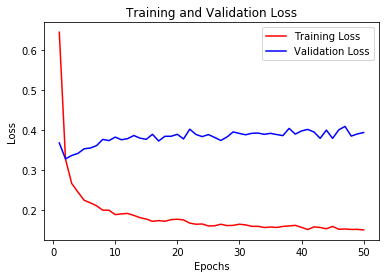

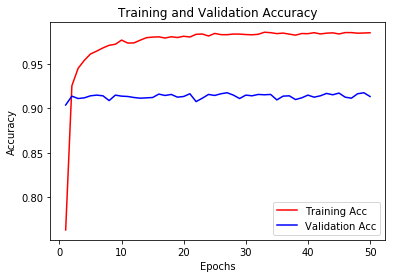

In [28]:
evaluate(dnn_uni, dnn_uni_history, test_uni, 'DNN Unigram')

DNN Bigram Evaluation: 
Accuracy:        0.9165705497885429
ROC AUC Score:   0.9158313503074825
F1 Score:        0.9119675456389452
Precision:       0.9382303839732888
Recall:          0.8871349644830308


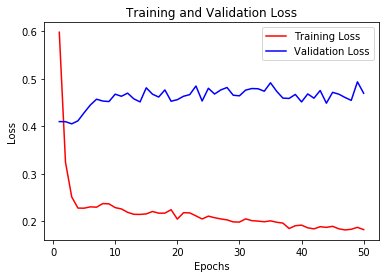

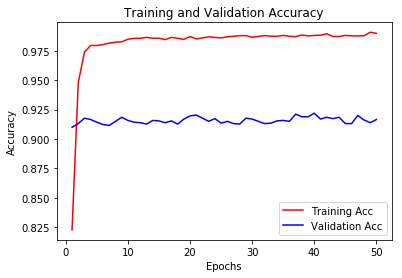

In [29]:
evaluate(dnn_big, dnn_big_history, test_big, 'DNN Bigram')

DNN TFIDF Evaluation: 
Accuracy:        0.9138792772010765
ROC AUC Score:   0.9133067641396351
F1 Score:        0.9097502014504433
Precision:       0.9292181069958848
Recall:          0.8910812943962115


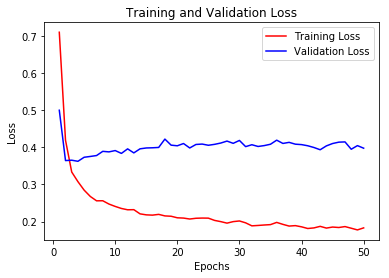

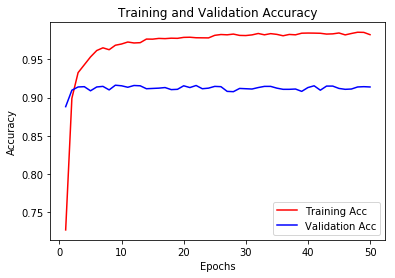

In [30]:
evaluate(dnn_tfidf, dnn_tfidf_history, test_tfidf, 'DNN TFIDF')

DNN Reduced Unigram Evaluation: 
Accuracy:        0.6893502499038832
ROC AUC Score:   0.6888664980848171
F1 Score:        0.6775738228252195
Precision:       0.6852300242130751
Recall:          0.67008681925809


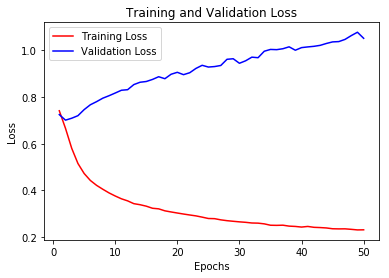

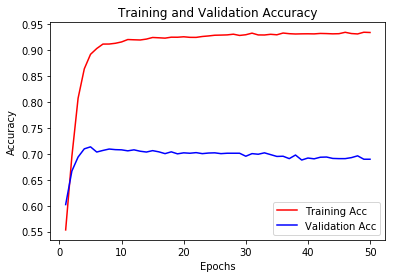

In [31]:
evaluate(dnn_runi, dnn_runi_history, test_runi, 'DNN Reduced Unigram')

DNN Reduced Bigram Evaluation: 
Accuracy:        0.673202614379085
ROC AUC Score:   0.6732234711373595
F1 Score:        0.6677091477716967
Precision:       0.6615027110766848
Recall:          0.6740331491712708


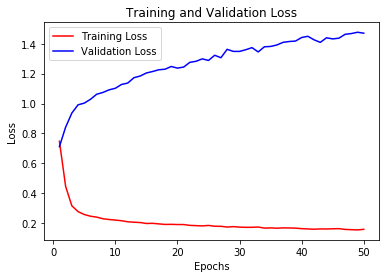

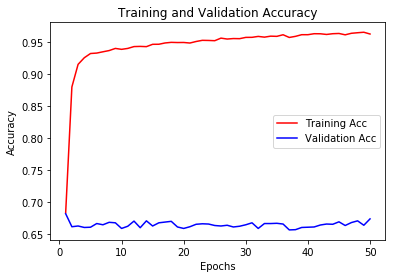

In [32]:
evaluate(dnn_rbig, dnn_rbig_history, test_rbig, 'DNN Reduced Bigram')

DNN Reduced TFIDF Evaluation: 
Accuracy:        0.5905420991926182
ROC AUC Score:   0.5937487057576185
F1 Score:        0.6308492201039861
Precision:       0.5624227441285538
Recall:          0.7182320441988951


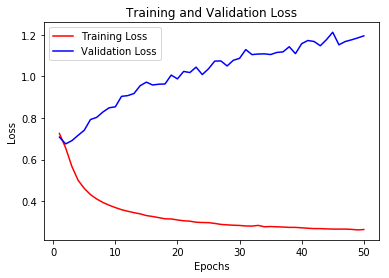

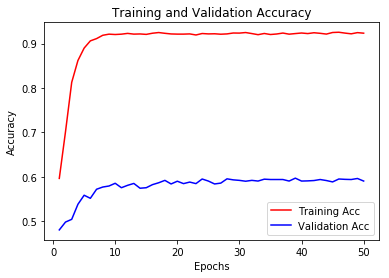

In [33]:
evaluate(dnn_rtfidf, dnn_rtfidf_history, test_rtfidf, 'DNN Reduced TFIDF')

DNN Word2Vec Evaluation: 
Accuracy:        0.5786236063052672
ROC AUC Score:   0.5781852562274505
F1 Score:        0.5647339158061955
Precision:       0.5683453237410072
Recall:          0.5611681136543015


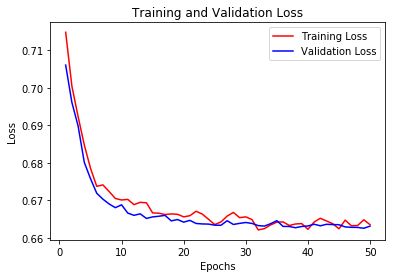

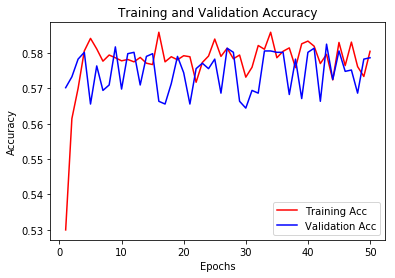

In [34]:
evaluate(dnn_vec, dnn_vec_history, test_vec, 'DNN Word2Vec')

# Training and Evaluating Convolutional Neural Networks

In [37]:
cnn_model, cnn_model_history, test_cnn = CNN()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 22, 32)            377408    
_________________________________________________________________
dropout_10 (Dropout)         (None, 22, 32)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 22, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 16)            1552      
_________________________________________________________________
flatten (Flatten)            (None, 176)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 176)              

Convolutional Neural Network Evaluation: 
Accuracy:        0.8719723183391004
ROC AUC Score:   0.8714611715452455
F1 Score:        0.8663187474909674
Precision:       0.8815359477124183
Recall:          0.8516179952644041


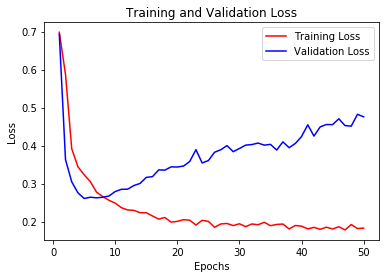

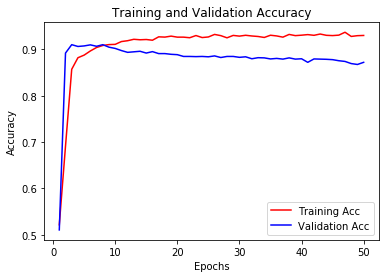

In [38]:
evaluate(cnn_model, cnn_model_history, test_cnn, 'Convolutional Neural Network')

# Training and Evaluating Recurrent Neural Networks

In [39]:
rnn_model, rnn_model_history, test_rnn = RNN()

W1214 14:54:44.925552 4321362816 deprecation.py:506] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 22, 64)            754816    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 22, 64)            0         
_________________________________________________________________
unified_lstm (UnifiedLSTM)   (None, 16)                5184      
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_13 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 5         
Total params: 760,073
Trainable params: 760,073
Non-trainable params: 0
________________________________________________

Recurrent Neural Network Evaluation: 
Accuracy:        0.8904267589388697
ROC AUC Score:   0.890423375526128
F1 Score:        0.8878394332939787
Precision:       0.8854003139717426
Recall:          0.8902920284135754


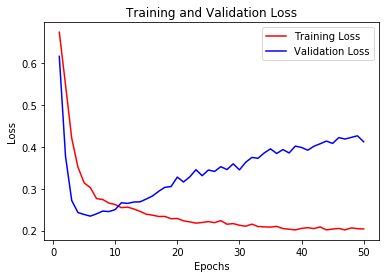

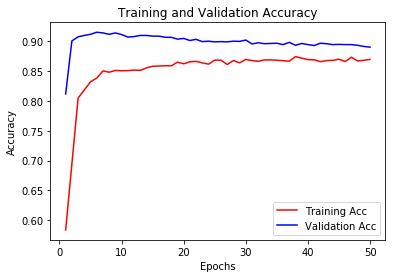

In [40]:
evaluate(rnn_model, rnn_model_history, test_rnn, 'Recurrent Neural Network')

# Training Deep Neural Networks - Early Stopping

### DNN Reduced Unigram

In [41]:
dnn_runi_s, dnn_runi_s_history = DNN(train_runi, test_runi, early_stop = True)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 5         
Total params: 6,569
Trainable params: 6,569
Non-trainable params: 0
_________________________________________________________________
2601/2601 [==============================] - 0s 36us/sample - loss: 0.6928 - accuracy: 0.6913
Training Time:   1.6661062240600586
Model Loss:      0.6928201826523469
Model Accuracy:  0.6912726


### DNN Reduced Bigram

In [42]:
dnn_rbig_s, dnn_rbig_s_history = DNN(train_rbig, test_rbig, early_stop = True)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 64)                32064     
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17        
Total params: 33,121
Trainable params: 33,121
Non-trainable params: 0
_________________________________________________________________
2601/2601 [==============================] - 0s 41us/sample - loss: 0.8903 - accuracy: 0.6509
Training Time:   1.690490961074829
Model Loss:      0.8903183404503763
Model Accuracy:  0.6509035


### DNN Reduced TFIDF

In [43]:
dnn_rtfidf_s, dnn_rtfidf_s_history = DNN(train_rtfidf, test_rtfidf, early_stop = True)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 5         
Total params: 6,569
Trainable params: 6,569
Non-trainable params: 0
_________________________________________________________________
2601/2601 [==============================] - 0s 34us/sample - loss: 0.6837 - accuracy: 0.5144
Training Time:   1.6676139831542969
Model Loss:      0.6836511272276791
Model Accuracy:  0.5144175


### DNN Word2Vec

In [44]:
dnn_vec_s, dnn_vec_s_history = DNN(train_vec, test_vec, early_stop = True)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 16)                1616      
_________________________________________________________________
dropout_17 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 5         
Total params: 1,689
Trainable params: 1,689
Non-trainable params: 0
_________________________________________________________________
2601/2601 [==============================] - 0s 32us/sample - loss: 0.6796 - accuracy: 0.5736
Training Time:   1.8758389949798584
Model Loss:      0.6795948549721251
Model Accuracy:  0.5736255


### DNN Unigram

In [45]:
dnn_uni_s, dnn_uni_s_history = DNN(train_uni, test_uni, early_stop = True)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 200)               2000200   
_________________________________________________________________
dropout_18 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_19 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 5         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
___________________________________________

### DNN Bigram

In [46]:
dnn_big_s, dnn_big_s_history = DNN(train_big, test_big, early_stop = True)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 200)               13000200  
_________________________________________________________________
dropout_20 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 5         
Total params: 13,006,769
Trainable params: 13,006,769
Non-trainable params: 0
_________________________________________

### DNN TFIDF

In [47]:
dnn_tfidf_s, dnn_tfidf_s_history = DNN(train_tfidf, test_tfidf, early_stop = True)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 200)               2000200   
_________________________________________________________________
dropout_22 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_23 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 5         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
___________________________________________

# Evaluating Deep Neural Networks - Early Stopping

DNN Unigram - Early Stop Evaluation: 
Accuracy:        0.9119569396386006
ROC AUC Score:   0.9110957544116656
F1 Score:        0.9066449245821443
Precision:       0.9376053962900506
Recall:          0.877663772691397


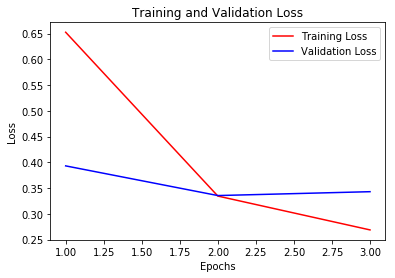

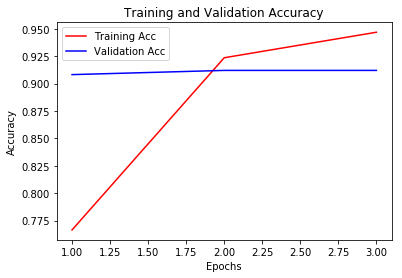

In [48]:
evaluate(dnn_uni_s, dnn_uni_s_history, test_uni, "DNN Unigram - Early Stop")

DNN Bigram - Early Stop Evaluation: 
Accuracy:        0.916955017301038
ROC AUC Score:   0.9162458036964154
F1 Score:        0.9124797406807131
Precision:       0.9375520399666945
Recall:          0.8887134964483031


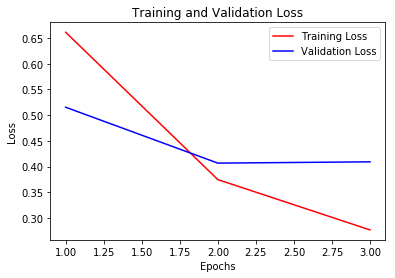

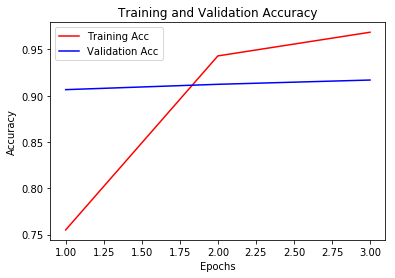

In [49]:
evaluate(dnn_big_s, dnn_big_s_history, test_big, "DNN Bigram - Early Stop")

DNN TFIDF - Early Stop Evaluation: 
Accuracy:        0.9150326797385621
ROC AUC Score:   0.914550124306434
F1 Score:        0.9112806101967083
Precision:       0.9272875816993464
Recall:          0.8958168902920284


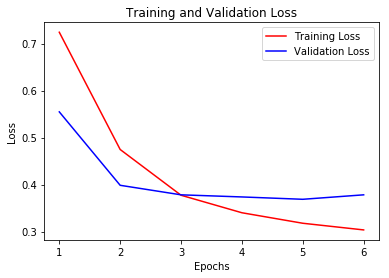

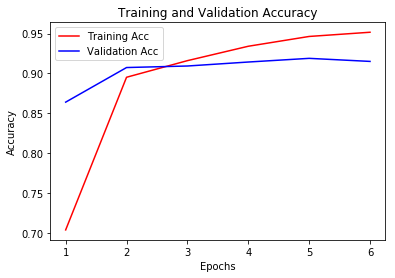

In [50]:
evaluate(dnn_tfidf_s, dnn_tfidf_s_history, test_tfidf, "DNN TFIDF - Early Stop")

DNN Word2Vec - Early Stop Evaluation: 
Accuracy:        0.5736255286428297
ROC AUC Score:   0.5765830581157725
F1 Score:        0.6123732960503322
Precision:       0.5495608531994981
Recall:          0.691397000789266


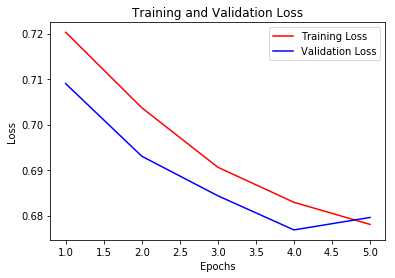

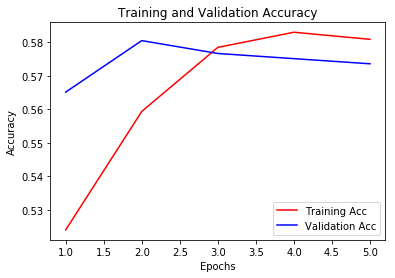

In [51]:
evaluate(dnn_vec_s, dnn_vec_s_history, test_vec, "DNN Word2Vec - Early Stop")

DNN Reduced Unigram - Early Stop Evaluation: 
Accuracy:        0.6912725874663591
ROC AUC Score:   0.6900864879320403
F1 Score:        0.6702258726899385
Precision:       0.6986301369863014
Recall:          0.6440410418310971


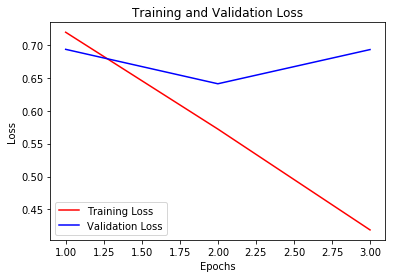

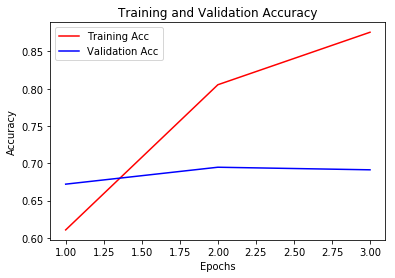

In [52]:
evaluate(dnn_runi_s, dnn_runi_s_history, test_runi, "DNN Reduced Unigram - Early Stop")

DNN Reduced Bigram - Early Stop Evaluation: 
Accuracy:        0.6509034986543637
ROC AUC Score:   0.6512266755335828
F1 Score:        0.6494208494208495
Precision:       0.63567649281935
Recall:          0.6637726913970008


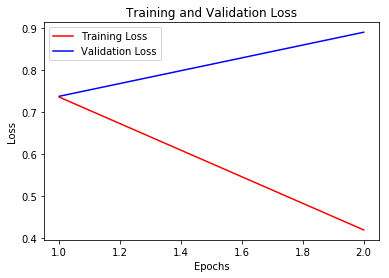

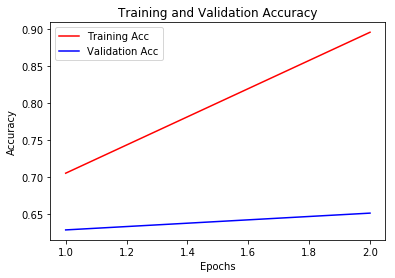

In [53]:
evaluate(dnn_rbig_s, dnn_rbig_s_history, test_rbig, "DNN Reduced Bigram - Early Stop")

DNN Reduced TFIDF - Early Stop Evaluation: 
Accuracy:        0.5144175317185697
ROC AUC Score:   0.5210619828207443
F1 Score:        0.6098239110287302
Precision:       0.5010152284263959
Recall:          0.7790055248618785


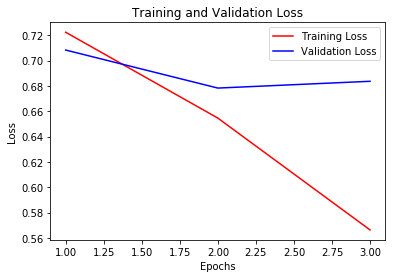

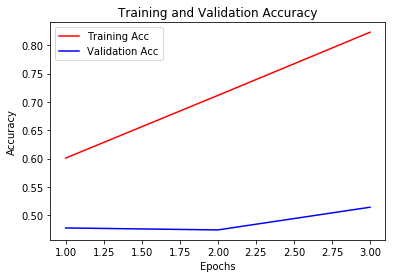

In [54]:
evaluate(dnn_rtfidf_s, dnn_rtfidf_s_history, test_rtfidf, "DNN Reduced TFIDF - Early Stop")

# Training and Evaluating Convolutional Neural Network - Early Stopping

In [55]:
cnn_stop, cnn_stop_history, test_cnn_stop = CNN(early_stop = True)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 22, 32)            377408    
_________________________________________________________________
dropout_24 (Dropout)         (None, 22, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 22, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 16)            1552      
_________________________________________________________________
flatten_1 (Flatten)          (None, 176)               0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 176)             

CNN - Early Stop Evaluation: 
Accuracy:        0.9150326797385621
ROC AUC Score:   0.9147285078849684
F1 Score:        0.9119170984455959
Precision:       0.9210950080515298
Recall:          0.9029202841357538


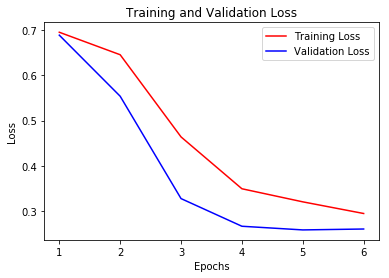

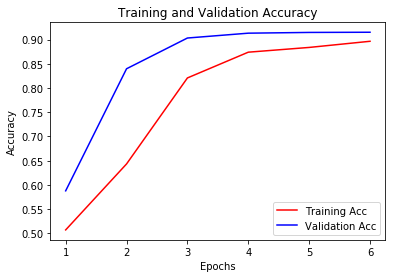

In [56]:
evaluate(cnn_stop, cnn_stop_history, test_cnn_stop, "CNN - Early Stop")

# Training and Evaluating Recurrent Neural Network - Early Stopping

In [57]:
rnn_stop, rnn_stop_history, test_rnn_stop = RNN(early_stop = True)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 22, 64)            754816    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 22, 64)            0         
_________________________________________________________________
unified_lstm_1 (UnifiedLSTM) (None, 16)                5184      
_________________________________________________________________
dense_54 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_27 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 5         
Total params: 760,073
Trainable params: 760,073
Non-trainable params: 0
_______________________________________________

RNN - Early Stop Evaluation: 
Accuracy:        0.9104190695886197
ROC AUC Score:   0.9094577612535485
F1 Score:        0.904625460499386
Precision:       0.939625850340136
Recall:          0.8721389108129439


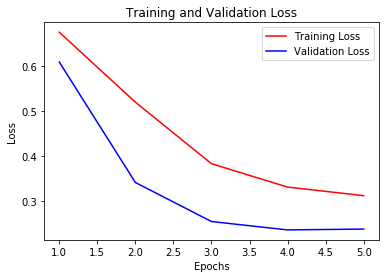

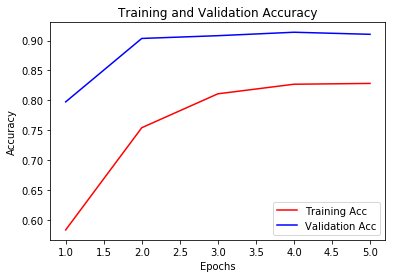

In [58]:
evaluate(rnn_stop, rnn_stop_history, test_rnn_stop, "RNN - Early Stop")